In [99]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import xgboost as xgb
from matplotlib.colors import LinearSegmentedColormap
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from pygam import LinearGAM, s, f
import sklearn
from joblib import dump, load
import joblib

In [2]:
# Load the dataset
malaria_df = pd.read_csv('C:/Users/Mrman/pypboi/Malaria_temp_prec_pop.csv')

In [3]:
# removal of potential whitespace in the 'Malaria_case_count' column
malaria_df['Malaria_case_count'] = malaria_df['Malaria_case_count'].str.replace(' ', '')

In [4]:
# Convert 'malaria_case_count' column to integer
malaria_df['Malaria_case_count'] = pd.to_numeric(malaria_df['Malaria_case_count'], errors='coerce')

# Check the data type of the column
print(malaria_df['Malaria_case_count'].dtype)

# Check for any NaN values introduced during the conversion
print(malaria_df['Malaria_case_count'].isnull().sum())

int64
0


## Feature creation

In [5]:
# create malaria cases per 100k people
malaria_df['Malaria_per_100k'] = (malaria_df['Malaria_case_count'] / malaria_df['Population']) * 100000

In [6]:
# feature engineering for log transformations and polynomial features
malaria_df['log_cases_per_100k'] = np.log1p(malaria_df['Malaria_per_100k'])  # log1p avoids issues with zeros
malaria_df['log_population'] = np.log1p(malaria_df['Population'])
malaria_df['temperature_squared'] = malaria_df['Avg_Temp'] ** 2
malaria_df['log_precipitation'] = np.log1p(malaria_df['Annual_precipitation'])

In [7]:
# assign x and y variables
X = malaria_df[['Avg_Temp', 'Annual_precipitation', 'Population']] #predictor
X_nopop = malaria_df[['Avg_Temp', 'Annual_precipitation']] #predictor without population
y = malaria_df['log_cases_per_100k'] #target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# training data without population
X_train_nopop, X_test_nopop, y_train_nopop, y_test_nopop = train_test_split(X_nopop, y, test_size=0.2, random_state=42)

## Determining best fit model

In [9]:
# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid, 
                      cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

# Get the best model and evaluate it
rf_best_model = rf_grid.best_estimator_
rf_y_pred = rf_best_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best Random Forest MSE: {rf_mse}")
print(f"Best Random Forest R²: {rf_r2}")

# Ridge Regression
ridge_param_grid = {
    'alpha': np.logspace(-3, 3, 7),
    'fit_intercept': [True, False],
    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg']
}

ridge = Ridge(random_state=42)
ridge_grid = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid,
                         cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Get the best model and evaluate it
ridge_best_model = ridge_grid.best_estimator_
ridge_y_pred = ridge_best_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_y_pred)
ridge_r2 = r2_score(y_test, ridge_y_pred)

print(f"Best Ridge parameters: {ridge_grid.best_params_}")
print(f"Best Ridge MSE: {ridge_mse}")
print(f"Best Ridge R²: {ridge_r2}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Random Forest parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest MSE: 1.8853520638801544
Best Random Forest R²: 0.8606200517782339
Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best Ridge parameters: {'alpha': 100.0, 'fit_intercept': True, 'solver': 'cholesky'}
Best Ridge MSE: 9.371071899737645
Best Ridge R²: 0.3072171817714635


In [10]:
# variance of y_test to compare against MSE
print(f"Variance of y_test: {y_test.var()}")

Variance of y_test: 13.603565761834163


## Training Model

In [11]:
rf_model = RandomForestRegressor(
    n_estimators=300,  # Number of trees
    max_depth=30,    # Maximum depth of trees 
    min_samples_split=2,  # Minimum samples required to split a node
    min_samples_leaf=1,   # Minimum samples required at each leaf node
    max_features='sqrt',  # Number of features to consider for best split
    random_state=42       # For reproducibility
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)


In [12]:
# obtain mse and r2 for both train and test sets
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# print the results
print(f"Training MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")
print(f"Training R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")

Training MSE: 0.351
Test MSE: 1.885
Training R²: 0.974
Test R²: 0.861


In [13]:
# variance of y_test to compare against MSE
print(f"Variance of y_test: {y_test.var()}")

Variance of y_test: 13.603565761834163


In [14]:
# Save the Random Forest model to a file
dump(rf_model, "malaria_randomforest_model.joblib")
print("Model saved as malaria_randomforest_model.joblib")

Model saved as malaria_randomforest_model.joblib


## Model Evaluation

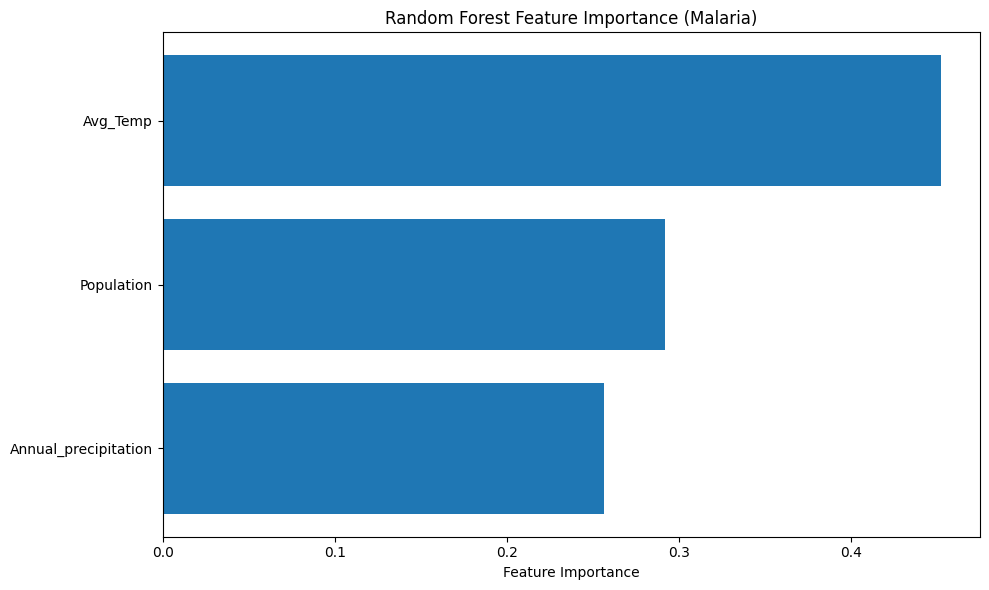

In [15]:
# Evaluation of feature importance
# Feature importance plot
feature_importance = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Malaria)')
plt.tight_layout()
plt.show()

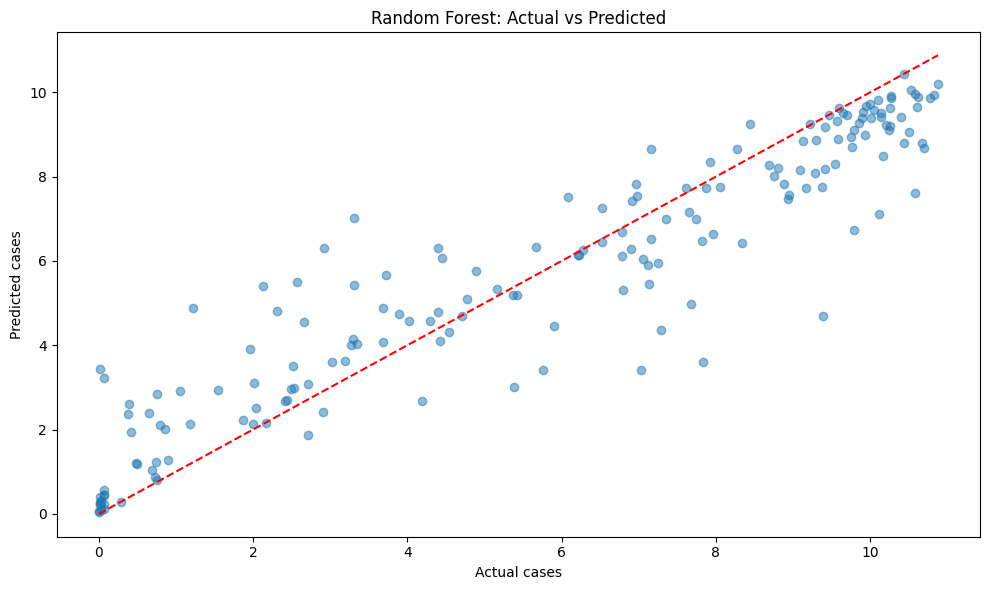

In [107]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual cases')
plt.ylabel('Predicted cases')
plt.title('Random Forest: Actual vs Predicted')
plt.tight_layout()
plt.show()

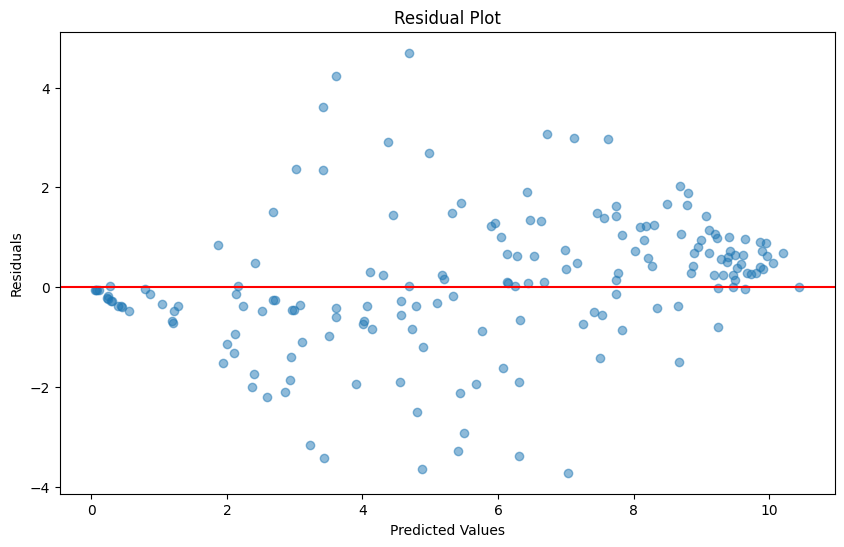

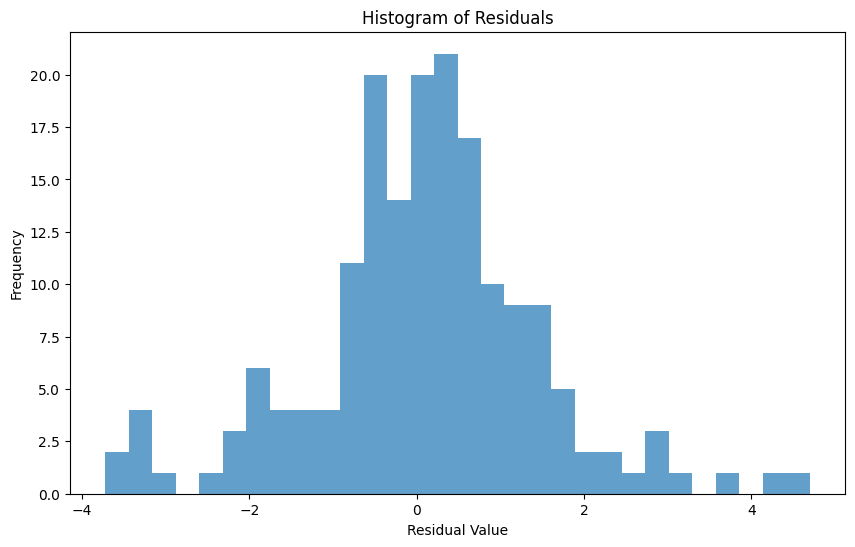

In [17]:
# Calculate residuals
residuals = y_test - y_pred_test

# Plot residuals vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [ ]:
# input api key
API_KEY = "**************************"  # Replace with your actual API key

# List of unique country names from your malaria dataset
locations = malaria_df['Country'].dropna().unique().tolist()
added_locations = [ 'Tanzania', 'Tanzania, United Republic of']
locations.extend(added_locations)

# Initialize an empty list to store results
weather_records = []

for country in locations:
    url = f"http://api.weatherstack.com/current"
    params = {
        "access_key": API_KEY,
        "query": country
    }

    response = requests.get(url, params=params)
    data = response.json()

    # Check if the response contains weather data
    if data.get("current") and data.get("location"):
        weather_records.append({
            "Country": data["location"]["country"],
            "Current_Temperature_C": data["current"]["temperature"]
        })
    else:
        print(f"Could not fetch data for {country} — response: {data.get('error', 'No error info')}")

# Convert the list of records into a DataFrame
weather_df = pd.DataFrame(weather_records)

# Display the results
print(weather_df.head(100))


Could not fetch data for Eswatini — response: {'code': 615, 'type': 'request_failed', 'info': 'Your API request failed. Please try again or contact support.'}
Could not fetch data for Türkiye — response: {'code': 615, 'type': 'request_failed', 'info': 'Your API request failed. Please try again or contact support.'}
                             Country  Current_Temperature_C
0                           Paraguay                     29
1                              Sudan                     31
2           Central African Republic                     31
3                        Philippines                     21
4       USA United States of America                     16
5                             Angola                     28
6                           Suriname                     29
7                            Eritrea                     17
8                           Colombia                     21
9                         Mauritania                     21
10                     

In [ ]:
#checking for differences in country names/spelling
print(sorted(weather_df['Country'].unique()))

['Afghanistan', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Azerbaijan', 'Bangladesh', 'Belize', 'Benin', 'Bhutan', 'Botswana', 'Brazil', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Democratic Republic of Congo', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'French Guiana', 'Gabon', 'Gambia', 'Georgia', 'Ghana', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'India', 'Indonesia', 'Kenya', "Lao People's Democratic Republic", 'Liberia', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mauritania', 'Mexico', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Nicaragua', 'Niger', 'Nigeria', 'Pakistan', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Rwanda', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'Somalia', 'South Africa', 'South Korea'

In [ ]:
#country renaming to match api
weather_df.loc[weather_df["Country"] == "Tanzania", "Country"] = "United Republic of Tanzania"

In [65]:
print(sorted(locations))

['Afghanistan', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Azerbaijan', 'Bangladesh', 'Belize', 'Benin', 'Bhutan', 'Bolivia (Plurinational State of)', 'Botswana', 'Brazil', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'French Guiana', 'Gabon', 'Gambia', 'Georgia', 'Ghana', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'India', 'Indonesia', 'Iran (Islamic Republic of)', 'Kenya', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Liberia', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mauritania', 'Mexico', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Nicaragua', 'Niger', 'Nigeria', 'Pakistan', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', '

In [ ]:

# Merge the weather data with the malaria data
map_merge = malaria_df.merge(weather_df, on="Country", how="left")
#map_merge["Current_Temperature_C"] = map_merge["Current_Temperature_C"].fillna(map_merge["Avg_Temp"])

print(map_merge.head(100))

   Code                                Country  Year  Malaria_case_count  \
0   PRY                               Paraguay  2023                   0   
1   SDN                                  Sudan  2023             1304528   
2   CAF               Central African Republic  2023             1979614   
3   IRN             Iran (Islamic Republic of)  2023               10004   
4   BOL       Bolivia (Plurinational State of)  2023               10297   
5   AGO                                 Angola  2023            10496880   
6   SUR                               Suriname  2023                 102   
7   ERI                                Eritrea  2023              102504   
8   COL                               Colombia  2023              105479   
9   MRT                             Mauritania  2023              108415   
10  BFA                           Burkina Faso  2023            11055698   
11  PAN                                 Panama  2023               11611   
12  GMB     

In [ ]:
#dropping NA values and renaming columns for clarity
filtered_map_merge = map_merge.dropna(subset=['Current_Temperature_C'])
filtered_map_merge.drop(columns=['Avg_Temp'], inplace=True, errors='ignore')
filtered_map_merge.rename(columns={'Current_Temperature_C':'Avg_Temp'}, inplace=True)

C:\Users\Mrman\AppData\Local\Temp1\ipykernel_68824\5831203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_map_merge.drop(columns=['Avg_Temp'], inplace=True, errors='ignore')
C:\Users\Mrman\AppData\Local\Temp1\ipykernel_68824\5831203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_map_merge.rename(columns={'Current_Temperature_C':'Avg_Temp'}, inplace=True)


In [ ]:
#loading model
rf_model = joblib.load("C:/Users/Mrman/pypboi/malaria_randomforest_model.joblib")

# assign features for prediction
features = filtered_map_merge[["Avg_Temp", "Annual_precipitation", "Population"]]

# Predict log malaria rate and then exponentiate to get back to per 100k scale
filtered_map_merge["Predicted_Malaria_per_100k"] = np.exp(rf_model.predict(features))

# Show top predictions
print(filtered_map_merge[["Country", "Predicted_Malaria_per_100k"]].head(30))

                     Country  Predicted_Malaria_per_100k
0                   Paraguay                 2346.705634
1                      Sudan                 5568.846542
2   Central African Republic                 9080.938775
5                     Angola                17306.448211
6                   Suriname                  165.615081
7                    Eritrea                    2.267992
8                   Colombia                   54.871264
9                 Mauritania                   94.287748
10              Burkina Faso                18312.894262
11                    Panama                  636.583516
12                    Gambia                 3979.702105
13             Guinea-Bissau                 5621.938216
14                Mozambique                 8324.856748
15                   Somalia                 6262.520422
16                   Namibia                   20.985923
18                     Gabon                 1363.566761
19                  Cambodia   

C:\Users\Mrman\AppData\Local\Temp1\ipykernel_68824\1689981625.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_map_merge["Predicted_Malaria_per_100k"] = np.exp(rf_model.predict(features))


In [ ]:
# loading map for visualization
world = gpd.read_file(r"c:\Users\Mrman\Downloads\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp")

In [ ]:
# checking column names
print(world.head(5))

        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  ...  \
0         0      2  Sovereign country   1                         Fiji  ...   
1         0      2  Sovereign country   1  United Republic of Tanzania  ...   
2         0      2      Indeterminate   1               Western Sahara  ...   
3         0      2  Sovereign country   1                       Canada  ...   
4         1      2            Country   1     United States of America  ...   

      FCLASS_TR     FCLASS_ID     FCLASS_PL 

In [ ]:
#further country name checks
pd.set_option('display.max_rows', None)  # Ensure all rows are displayed
pd.set_option('display.max_colwidth', None)  # Ensure no truncation of column content
print(sorted(world['ADMIN'].unique()))

['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antarctica', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Islands', 'Fiji', 'Finland', 'France', 'French Southern and Antarctic Lands', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Jordan

In [92]:
print(sorted(filtered_map_merge['Country'].unique()))

['Afghanistan', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Azerbaijan', 'Bangladesh', 'Belize', 'Benin', 'Bhutan', 'Botswana', 'Brazil', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'French Guiana', 'Gabon', 'Gambia', 'Georgia', 'Ghana', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'India', 'Indonesia', 'Kenya', "Lao People's Democratic Republic", 'Liberia', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mauritania', 'Mexico', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Nicaragua', 'Niger', 'Nigeria', 'Pakistan', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Rwanda', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'Somalia', 'South Africa', 'Sri Lanka', 'Sudan', 'Suriname', 'Tajikistan

In [94]:
# Replace country names in the world GeoDataFrame with those in the malaria DataFrame
world.loc[world["ADMIN"] == "Ivory Coast", "ADMIN"] = "Cote d'Ivoire"
world.loc[world["ADMIN"] == "Republic of the Congo", "ADMIN"] = "Congo"
world.loc[world["ADMIN"] == "Guyane", "ADMIN"] = "French Guiana"
world.loc[world["ADMIN"] == "Democratic Republic of the Congo", "ADMIN"] = "Congo"
world.loc[world["ADMIN"] == "Bolivia", "ADMIN"] = "Bolivia (Plurinational State of)"
world.loc[world["ADMIN"] == "Venezuela", "ADMIN"] = "Venezuela (Bolivarian Republic of)"
world.loc[world["ADMIN"] == "Iran", "ADMIN"] = "Iran (Islamic Republic of)"
world.loc[world["ADMIN"] == "North Korea", "ADMIN"] = "Democratic People's Republic of Korea"
world.loc[world["ADMIN"] == "Turkey", "ADMIN"] = "Türkiye"
world.loc[world["ADMIN"] == "Vietnam", "ADMIN"] = "Viet Nam"
world.loc[world["ADMIN"] == "East Timor", "ADMIN"] = "Timor-Leste"
world.loc[world["ADMIN"] == "South Sudan", "ADMIN"] = "Sudan"

In [95]:
# Merge the filtered map merge DataFrame with the world GeoDataFrame
world = world.merge(filtered_map_merge, left_on="ADMIN", right_on="Country", how="left")
world['Predicted_Malaria_per_100k'] = world['Predicted_Malaria_per_100k'].fillna(0)

In [96]:
bins = [0, 100, 5000, 10000, np.inf]  # bins to categorize the malaria risk
labels = ['Low', 'Moderate', 'High', 'Very High']

world['malaria_risk'] = pd.cut(world['Predicted_Malaria_per_100k'], bins=bins, labels=labels)


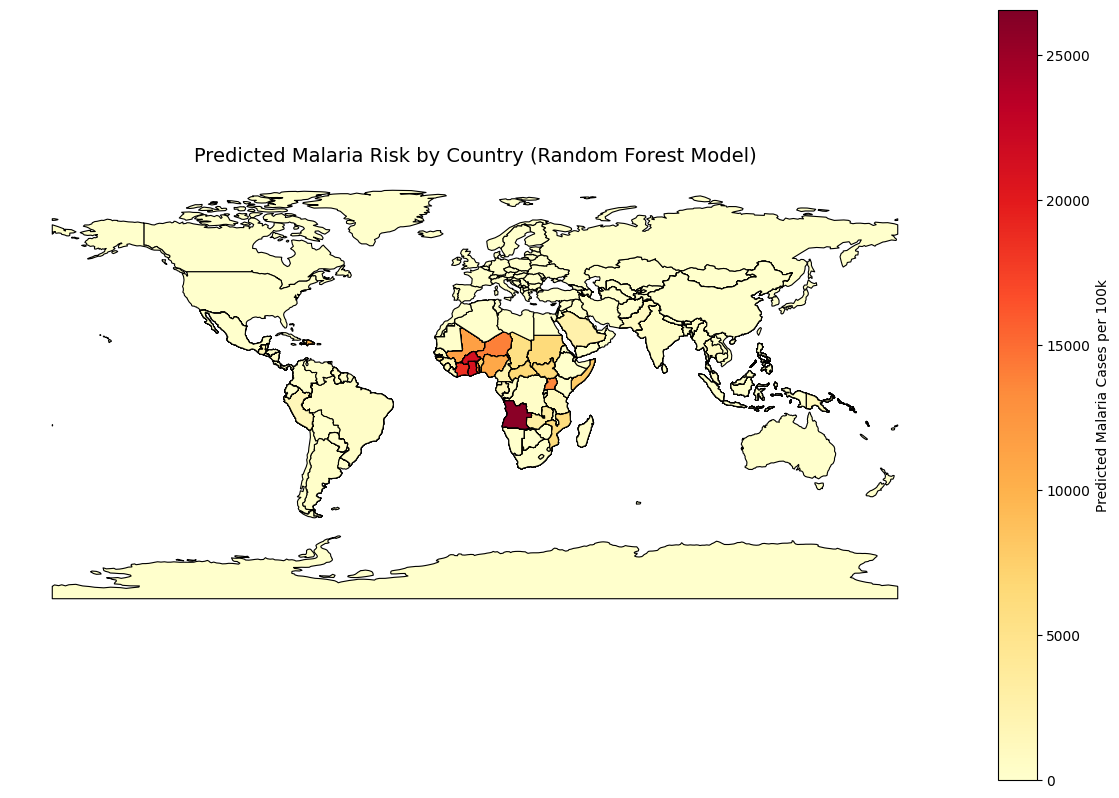

In [97]:
# Create map of predicted malaria risk
# Set up the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the map, using malaria predictions for color scaling
world.plot(column='Predicted_Malaria_per_100k', cmap='YlOrRd', linewidth=0.8, edgecolor='black',
           legend=True, legend_kwds={'label': "Predicted Malaria Cases per 100k"}, ax=ax)
plt.axis("off")

# Add title
plt.title("Predicted Malaria Risk by Country (Random Forest Model)", fontsize=14)

# Show the map
plt.show()

In [103]:
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

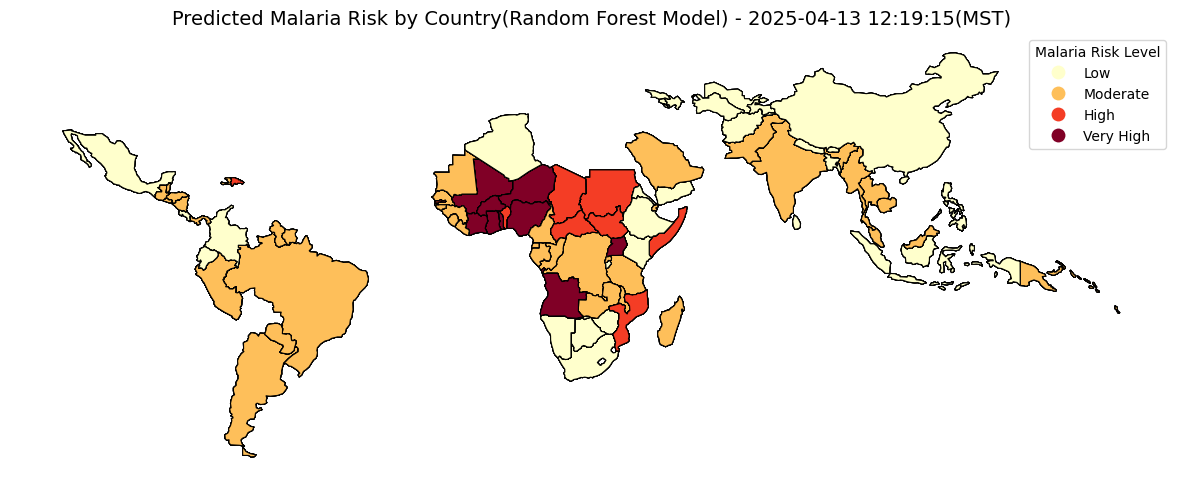

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot map with malaria risk levels
world.plot(column='malaria_risk', cmap='YlOrRd', linewidth=0.8, edgecolor='black',
           legend=True, legend_kwds={'title': "Malaria Risk Level"}, ax=ax)

plt.axis("off")
plt.title(f"Predicted Malaria Risk by Country(Random Forest Model) - {current_datetime}(MST)", fontsize=14)
plt.show()
